In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.segmentation import fcn_resnet50
from PIL import Image
import os
import numpy as np
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [2]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
import numpy as np

class IDDSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, augment=False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.augment = augment
        self.image_paths = []
        self.mask_paths = []

        # Traverse through subdirectories
        for city_folder in os.listdir(image_dir):
            city_image_folder = os.path.join(image_dir, city_folder)
            city_mask_folder = os.path.join(mask_dir, city_folder)

            if os.path.isdir(city_image_folder) and os.path.isdir(city_mask_folder):
                for img_file in os.listdir(city_image_folder):
                    if img_file.endswith('.jpg') or img_file.endswith('.png'):
                        img_path = os.path.join(city_image_folder, img_file)
                        mask_file = img_file.replace('leftImg8bit', 'mask')
                        mask_path = os.path.join(city_mask_folder, mask_file)

                        if os.path.exists(img_path) and os.path.exists(mask_path):
                            self.image_paths.append(img_path)
                            self.mask_paths.append(mask_path)
                        else:
                            print(f"Skipping: Image or mask not found for {img_file}")

        print(f"Number of images found: {len(self.image_paths)}")
        print(f"First few image paths: {self.image_paths[:5]}")

    def __len__(self):
        return len(self.image_paths)

    def augment_data(self, image, mask):
        # Randomly flip images and masks horizontally
        if torch.rand(1) > 0.5:
            image = transforms.functional.hflip(image)
            mask = transforms.functional.hflip(mask)

        # Randomly flip images and masks vertically
        if torch.rand(1) > 0.5:
            image = transforms.functional.vflip(image)
            mask = transforms.functional.vflip(mask)

        # Apply random brightness adjustment
        if torch.rand(1) > 0.5:
            image = transforms.functional.adjust_brightness(image, torch.rand(1).item() + 0.5)

        # Apply random contrast adjustment
        if torch.rand(1) > 0.5:
            image = transforms.functional.adjust_contrast(image, torch.rand(1).item() + 0.5)
        
        return image, mask

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        # Load image as RGB and mask as grayscale
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # 'L' mode for grayscale

        # Apply transforms, if any
        if self.transform:
            image = self.transform(image)
            mask = transforms.functional.resize(mask, image.shape[1:])  # Resize mask to match image size
            mask = torch.from_numpy(np.array(mask))  # Convert to tensor as a 2D tensor

        # Ensure mask is a LongTensor and has class indices (0-38)
        mask = mask.long()

        # Apply augmentation, if needed
        if self.augment:
            image, mask = self.augment_data(image, mask)

        return image, mask.squeeze()  # Ensure mask remains 2D (H, W)


In [3]:
from typing import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=38, init_features=64):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return self.conv(dec1)

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        f"{name}_conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (f"{name}_norm1", nn.BatchNorm2d(num_features=features)),
                    (f"{name}_relu1", nn.ReLU(inplace=True)),
                    (
                        f"{name}_conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (f"{name}_norm2", nn.BatchNorm2d(num_features=features)),
                    (f"{name}_relu2", nn.ReLU(inplace=True)),
                ]
            )
        )


In [4]:
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm  # For progress bar

# Example training loop for the U-Net model
def train_model(model, train_dataloader, val_dataloader=None, num_epochs=20, learning_rate=0.001, device='cuda'):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()  # For multi-class segmentation

    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, masks in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}")

        if val_dataloader:
            val_loss = validate_model(model, val_dataloader, criterion, device)
            print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), "best_unet_model.pth")
                print(f"Saved best model with validation loss: {best_val_loss:.4f}")

def validate_model(model, val_dataloader, criterion, device):
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, masks in tqdm(val_dataloader, desc="Validating"):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_dataloader)
    return avg_val_loss


In [5]:
# Example transformations
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to a smaller image size for faster training
    transforms.ToTensor(),  # Convert image to PyTorch tensor
])

# Setup dataset and dataloaders
train_dataset = IDDSegmentationDataset(
    image_dir=r"C:\Users\sayantan\DIP\IDD_Segmentation\leftImg8bit\train",
    mask_dir=r"C:\Users\sayantan\DIP\IDD_Segmentation\masks\train",
    transform=transform,
    augment=True
)

val_dataset = IDDSegmentationDataset(
    image_dir=r"C:\Users\sayantan\DIP\IDD_Segmentation\leftImg8bit\val",
    mask_dir=r"C:\Users\sayantan\DIP\IDD_Segmentation\masks\val",
    transform=transform
)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Initialize U-Net model and train
unet_model = UNet(in_channels=3, out_channels=39)
train_model(unet_model, train_dataloader, val_dataloader, num_epochs=20, learning_rate=0.001, device='cuda')


Number of images found: 6993
First few image paths: ['C:\\Users\\sayantan\\DIP\\IDD_Segmentation\\leftImg8bit\\train\\0\\005506_leftImg8bit.png', 'C:\\Users\\sayantan\\DIP\\IDD_Segmentation\\leftImg8bit\\train\\0\\005626_leftImg8bit.png', 'C:\\Users\\sayantan\\DIP\\IDD_Segmentation\\leftImg8bit\\train\\0\\006741_leftImg8bit.png', 'C:\\Users\\sayantan\\DIP\\IDD_Segmentation\\leftImg8bit\\train\\0\\006861_leftImg8bit.png', 'C:\\Users\\sayantan\\DIP\\IDD_Segmentation\\leftImg8bit\\train\\0\\007325_leftImg8bit.png']
Number of images found: 981
First few image paths: ['C:\\Users\\sayantan\\DIP\\IDD_Segmentation\\leftImg8bit\\val\\119\\035471_leftImg8bit.png', 'C:\\Users\\sayantan\\DIP\\IDD_Segmentation\\leftImg8bit\\val\\119\\038937_leftImg8bit.png', 'C:\\Users\\sayantan\\DIP\\IDD_Segmentation\\leftImg8bit\\val\\119\\107588_leftImg8bit.png', 'C:\\Users\\sayantan\\DIP\\IDD_Segmentation\\leftImg8bit\\val\\119\\171342_leftImg8bit.png', 'C:\\Users\\sayantan\\DIP\\IDD_Segmentation\\leftImg8bit\\

Epoch 1/20 - Training: 100%|██████████| 875/875 [08:09<00:00,  1.79it/s]


Epoch [1/20], Training Loss: 1.5053


Validating: 100%|██████████| 123/123 [00:41<00:00,  2.99it/s]


Epoch [1/20], Validation Loss: 1.4054
Saved best model with validation loss: 1.4054


Epoch 2/20 - Training: 100%|██████████| 875/875 [07:47<00:00,  1.87it/s]


Epoch [2/20], Training Loss: 1.2184


Validating: 100%|██████████| 123/123 [00:43<00:00,  2.83it/s]


Epoch [2/20], Validation Loss: 1.1740
Saved best model with validation loss: 1.1740


Epoch 3/20 - Training: 100%|██████████| 875/875 [07:44<00:00,  1.88it/s]


Epoch [3/20], Training Loss: 1.1192


Validating: 100%|██████████| 123/123 [00:38<00:00,  3.19it/s]


Epoch [3/20], Validation Loss: 1.1246
Saved best model with validation loss: 1.1246


Epoch 4/20 - Training: 100%|██████████| 875/875 [07:34<00:00,  1.93it/s]


Epoch [4/20], Training Loss: 1.0551


Validating: 100%|██████████| 123/123 [00:38<00:00,  3.19it/s]


Epoch [4/20], Validation Loss: 0.9673
Saved best model with validation loss: 0.9673


Epoch 5/20 - Training: 100%|██████████| 875/875 [07:42<00:00,  1.89it/s]


Epoch [5/20], Training Loss: 0.9926


Validating: 100%|██████████| 123/123 [00:39<00:00,  3.14it/s]


Epoch [5/20], Validation Loss: 0.9391
Saved best model with validation loss: 0.9391


Epoch 6/20 - Training: 100%|██████████| 875/875 [07:31<00:00,  1.94it/s]


Epoch [6/20], Training Loss: 0.9536


Validating: 100%|██████████| 123/123 [00:39<00:00,  3.14it/s]


Epoch [6/20], Validation Loss: 0.9212
Saved best model with validation loss: 0.9212


Epoch 7/20 - Training: 100%|██████████| 875/875 [07:30<00:00,  1.94it/s]


Epoch [7/20], Training Loss: 0.9112


Validating: 100%|██████████| 123/123 [00:39<00:00,  3.14it/s]


Epoch [7/20], Validation Loss: 0.8690
Saved best model with validation loss: 0.8690


Epoch 8/20 - Training: 100%|██████████| 875/875 [07:31<00:00,  1.94it/s]


Epoch [8/20], Training Loss: 0.8814


Validating: 100%|██████████| 123/123 [00:39<00:00,  3.15it/s]


Epoch [8/20], Validation Loss: 0.8876


Epoch 9/20 - Training: 100%|██████████| 875/875 [07:30<00:00,  1.94it/s]


Epoch [9/20], Training Loss: 0.8449


Validating: 100%|██████████| 123/123 [00:39<00:00,  3.14it/s]


Epoch [9/20], Validation Loss: 0.8383
Saved best model with validation loss: 0.8383


Epoch 10/20 - Training: 100%|██████████| 875/875 [07:31<00:00,  1.94it/s]


Epoch [10/20], Training Loss: 0.8261


Validating: 100%|██████████| 123/123 [00:39<00:00,  3.14it/s]


Epoch [10/20], Validation Loss: 0.8139
Saved best model with validation loss: 0.8139


Epoch 11/20 - Training: 100%|██████████| 875/875 [07:30<00:00,  1.94it/s]


Epoch [11/20], Training Loss: 0.7959


Validating: 100%|██████████| 123/123 [00:38<00:00,  3.16it/s]


Epoch [11/20], Validation Loss: 0.8305


Epoch 12/20 - Training: 100%|██████████| 875/875 [07:29<00:00,  1.95it/s]


Epoch [12/20], Training Loss: 0.7791


Validating: 100%|██████████| 123/123 [00:39<00:00,  3.15it/s]


Epoch [12/20], Validation Loss: 0.7808
Saved best model with validation loss: 0.7808


Epoch 13/20 - Training: 100%|██████████| 875/875 [07:30<00:00,  1.94it/s]


Epoch [13/20], Training Loss: 0.7627


Validating: 100%|██████████| 123/123 [00:39<00:00,  3.15it/s]


Epoch [13/20], Validation Loss: 0.7944


Epoch 14/20 - Training: 100%|██████████| 875/875 [07:29<00:00,  1.95it/s]


Epoch [14/20], Training Loss: 0.7444


Validating: 100%|██████████| 123/123 [00:39<00:00,  3.15it/s]


Epoch [14/20], Validation Loss: 0.7604
Saved best model with validation loss: 0.7604


Epoch 15/20 - Training: 100%|██████████| 875/875 [07:29<00:00,  1.95it/s]


Epoch [15/20], Training Loss: 0.7222


Validating: 100%|██████████| 123/123 [00:38<00:00,  3.16it/s]


Epoch [15/20], Validation Loss: 0.7597
Saved best model with validation loss: 0.7597


Epoch 16/20 - Training: 100%|██████████| 875/875 [07:29<00:00,  1.95it/s]


Epoch [16/20], Training Loss: 0.7180


Validating: 100%|██████████| 123/123 [00:39<00:00,  3.15it/s]


Epoch [16/20], Validation Loss: 0.7250
Saved best model with validation loss: 0.7250


Epoch 17/20 - Training: 100%|██████████| 875/875 [07:28<00:00,  1.95it/s]


Epoch [17/20], Training Loss: 0.7000


Validating: 100%|██████████| 123/123 [00:38<00:00,  3.16it/s]


Epoch [17/20], Validation Loss: 0.7172
Saved best model with validation loss: 0.7172


Epoch 18/20 - Training: 100%|██████████| 875/875 [07:29<00:00,  1.95it/s]


Epoch [18/20], Training Loss: 0.6877


Validating: 100%|██████████| 123/123 [00:38<00:00,  3.15it/s]


Epoch [18/20], Validation Loss: 0.7215


Epoch 19/20 - Training: 100%|██████████| 875/875 [07:29<00:00,  1.95it/s]


Epoch [19/20], Training Loss: 0.6762


Validating: 100%|██████████| 123/123 [00:38<00:00,  3.16it/s]


Epoch [19/20], Validation Loss: 0.7019
Saved best model with validation loss: 0.7019


Epoch 20/20 - Training: 100%|██████████| 875/875 [07:28<00:00,  1.95it/s]


Epoch [20/20], Training Loss: 0.6671


Validating: 100%|██████████| 123/123 [00:39<00:00,  3.15it/s]

Epoch [20/20], Validation Loss: 0.6960
Saved best model with validation loss: 0.6960


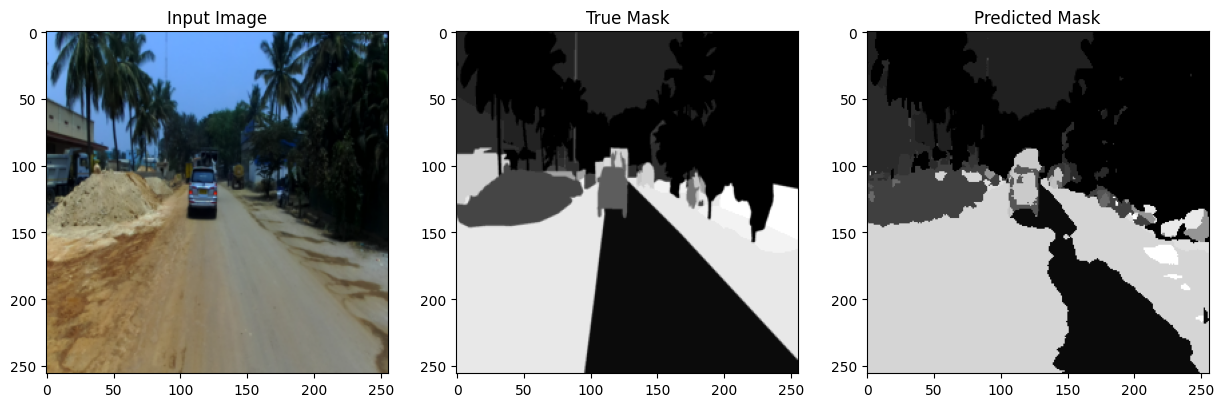

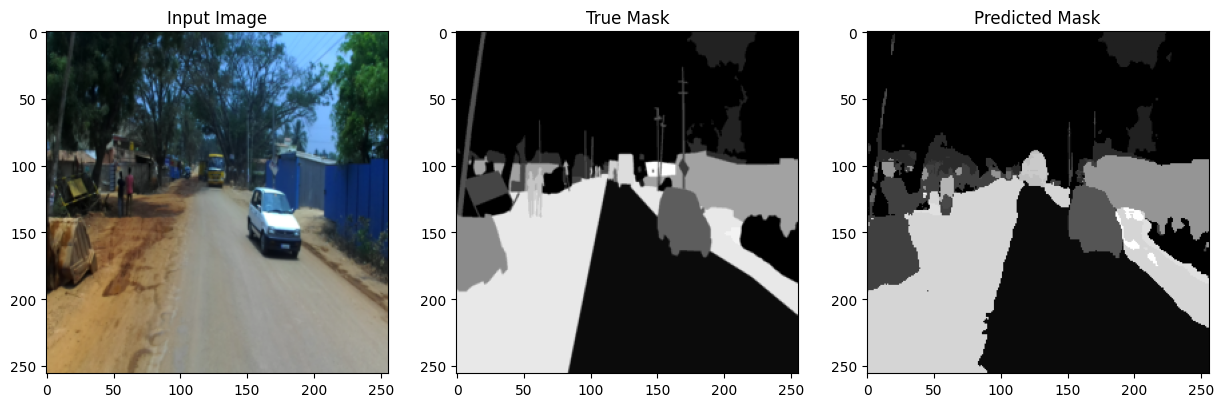

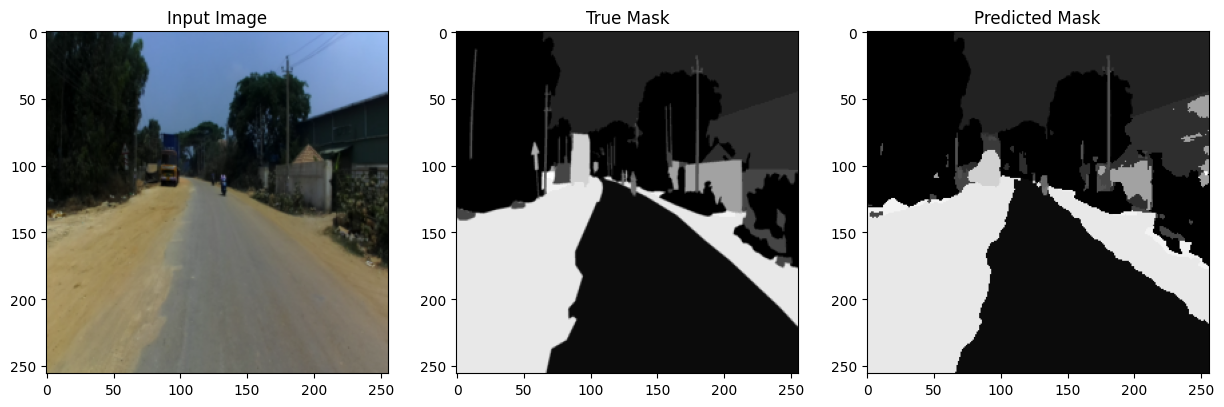

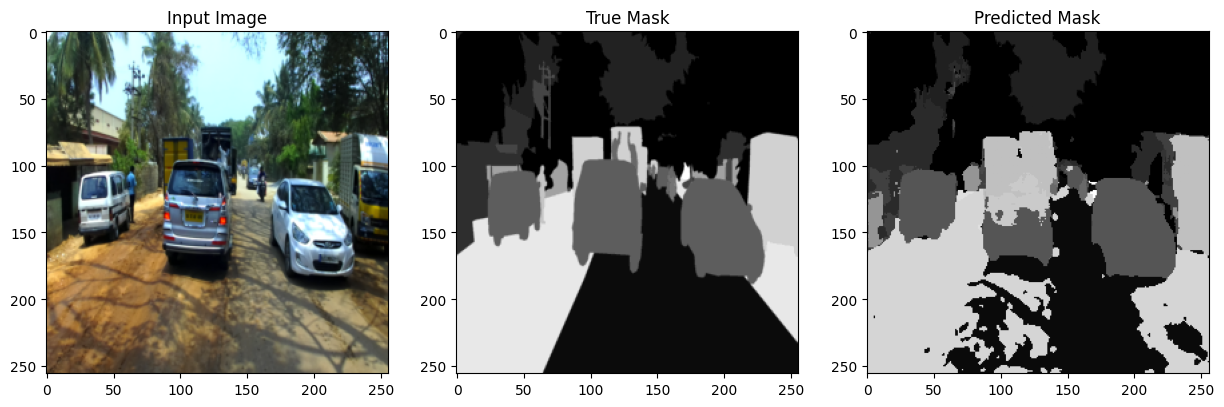

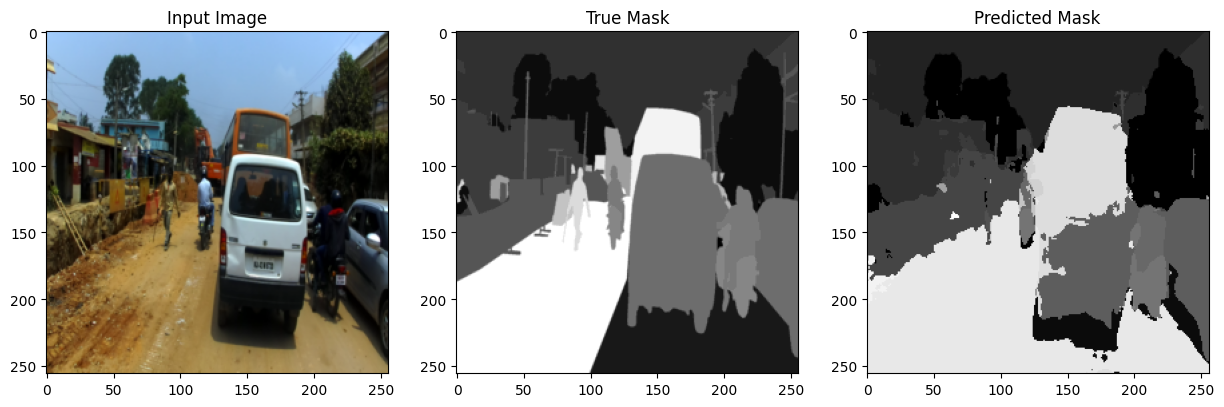

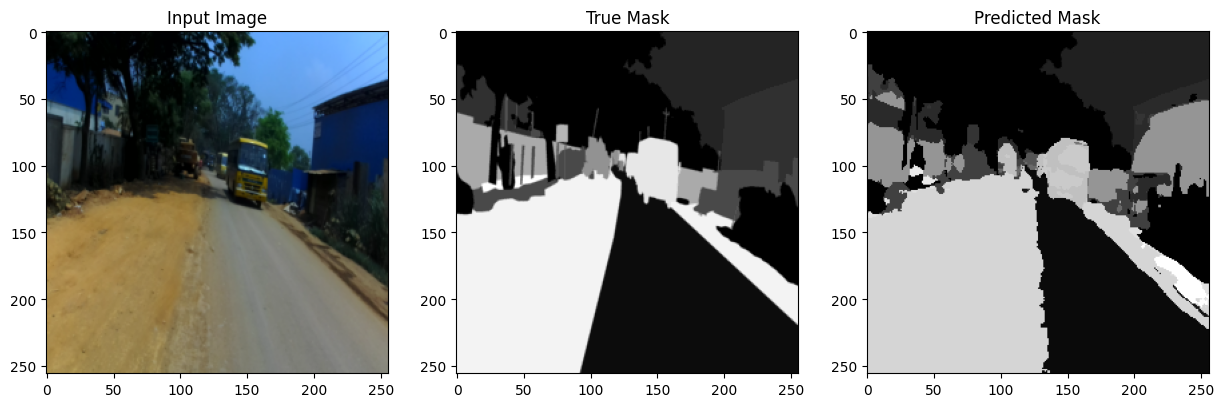

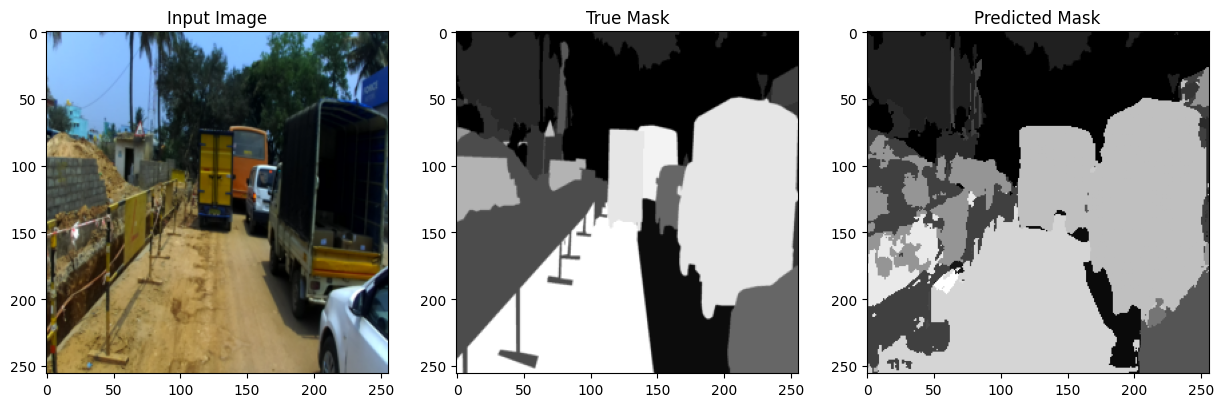

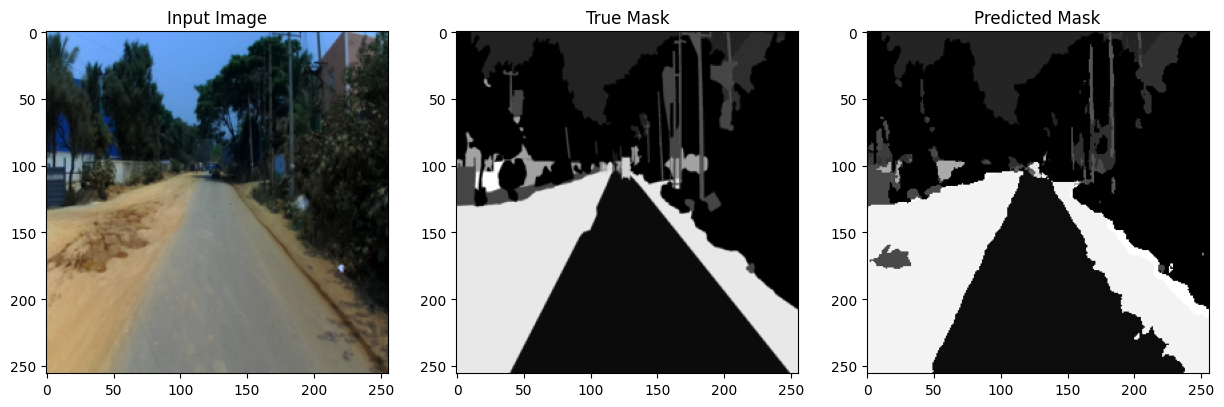

In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def visualize_prediction(model, dataloader, device, num_classes=39):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)
            
            # Move tensors to CPU for visualization
            images = images.cpu().numpy().transpose(0, 2, 3, 1)  # Convert to HWC format
            masks = masks.cpu().numpy()
            predictions = predictions.cpu().numpy()

            for i in range(len(images)):
                image = images[i]
                mask = masks[i]
                prediction = predictions[i]
                
                # Visualization
                fig, ax = plt.subplots(1, 3, figsize=(15, 5))
                ax[0].imshow(image)
                ax[0].set_title('Input Image')

                ax[1].imshow(mask, cmap='gray')
                ax[1].set_title('True Mask')

                ax[2].imshow(prediction, cmap='gray')
                ax[2].set_title('Predicted Mask')
                
                plt.show()

            break  # Display for one batch

# Call the function for visualization
visualize_prediction(unet_model, val_dataloader, device='cuda')


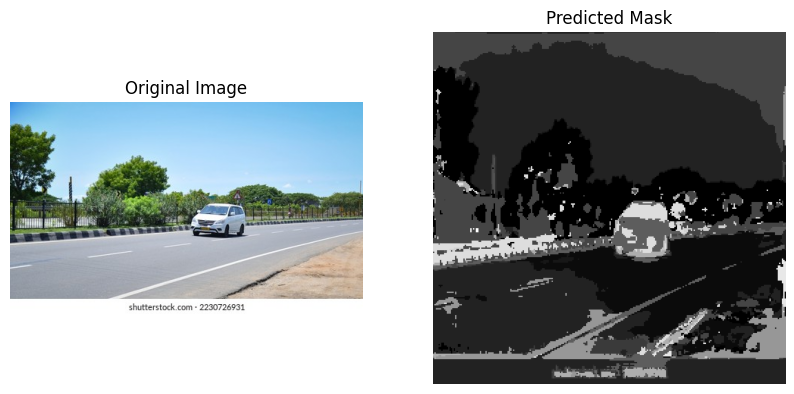

In [10]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

def load_custom_image(image_path, device, img_size=(256, 256)):
    # Load and preprocess image
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    image_tensor = image_tensor.to(device)
    return image, image_tensor  # Return both the original image and the tensor

def predict_custom_image(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        prediction = torch.argmax(output, dim=1).squeeze().cpu().numpy()
        return prediction

# Load custom image and make predictions
image_path = r'C:\Users\sayantan\DIP\viluppuram-india-august-28th-2022-260nw-2230726931.jpg'  # Path to your image
original_image, custom_image_tensor = load_custom_image(image_path, device='cuda')
prediction = predict_custom_image(unet_model, custom_image_tensor, device='cuda')

# Visualize the original image and predicted mask side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Show the original image
ax[0].imshow(original_image)
ax[0].set_title('Original Image')
ax[0].axis('off')  # Hide axis for clarity

# Show the predicted mask
ax[1].imshow(prediction, cmap='gray')
ax[1].set_title('Predicted Mask')
ax[1].axis('off')  # Hide axis for clarity

plt.show()


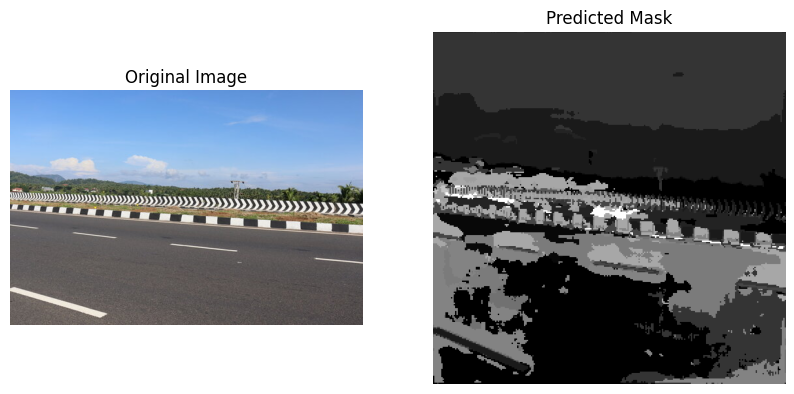

In [11]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

def load_custom_image(image_path, device, img_size=(256, 256)):
    # Load and preprocess image
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    image_tensor = image_tensor.to(device)
    return image, image_tensor  # Return both the original image and the tensor

def predict_custom_image(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        prediction = torch.argmax(output, dim=1).squeeze().cpu().numpy()
        return prediction

# Load custom image and make predictions
image_path = r'C:\Users\sayantan\DIP\360_F_452927980_Fkj7oNc4BgsW4hGoTuyUEuKiBUuQJ9G2.jpg'  # Path to your image
original_image, custom_image_tensor = load_custom_image(image_path, device='cuda')
prediction = predict_custom_image(unet_model, custom_image_tensor, device='cuda')

# Visualize the original image and predicted mask side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Show the original image
ax[0].imshow(original_image)
ax[0].set_title('Original Image')
ax[0].axis('off')  # Hide axis for clarity

# Show the predicted mask
ax[1].imshow(prediction, cmap='gray')
ax[1].set_title('Predicted Mask')
ax[1].axis('off')  # Hide axis for clarity

plt.show()
